To do:
- singnal estension
- weekly psf
- same analysis from wavelet filter
- adjust load and psf size (date on x axis)

In [1]:
import numpy as np 
import pandas as pd 
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_squared_error as mse
import sys
sys.path.append("../lib/")
from utils import *
from analysis import * 

In [2]:
data = pd.read_csv("../Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)

Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0

Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')
Electric['Seconds'] = (Electric.Date - Electric.Date[0]).dt.total_seconds()
Electric = Electric[['Date', 'Seconds', 'Load']]
Electric['Day'] = Electric['Date'].dt.day_name()
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour
Electric.columns

Electric

,Date,Seconds,Load,Day,Minutes,Hour
0,2008-01-01 00:15:00,0.0,15938.8,Tuesday,15,0
1,2008-01-01 00:30:00,900.0,15770.4,Tuesday,30,0
2,2008-01-01 00:45:00,1800.0,15766.3,Tuesday,45,0
3,2008-01-01 01:00:00,2700.0,15415.2,Tuesday,0,1
4,2008-01-01 01:15:00,3600.0,15351.8,Tuesday,15,1
...,...,...,...,...,...,...
315643,2016-12-31 23:00:00,284078700.0,15952.7,Saturday,0,23
315644,2016-12-31 23:15:00,284079600.0,15865.3,Saturday,15,23
315645,2016-12-31 23:30:00,284080500.0,15693.5,Saturday,30,23
315646,2016-12-31 23:45:00,284081400.0,15508.3,Saturday,45,23


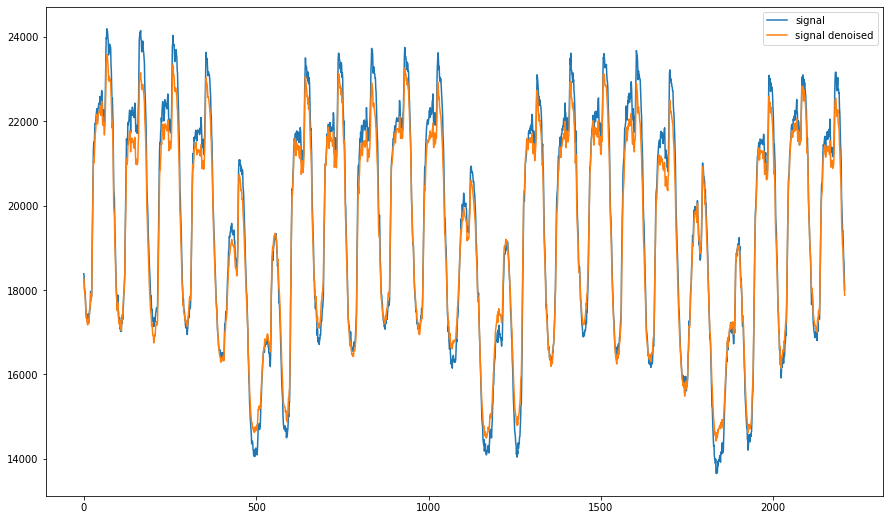

In [52]:
Load_denoised = wavelet_filter(Electric.Load.to_numpy(), wavelet='coif5', threshold=0.06)

plt.figure(figsize=(15, 9))
plt.plot(Electric.Load.to_numpy()[96*7:96*30], label='signal')
plt.plot(Load_denoised[96*7:96*30], label='signal denoised')
plt.legend()

In [3]:
# Week
signal_reconstr = fourierExtrapolation(Electric.Load.values, int(0), n_harm=10)

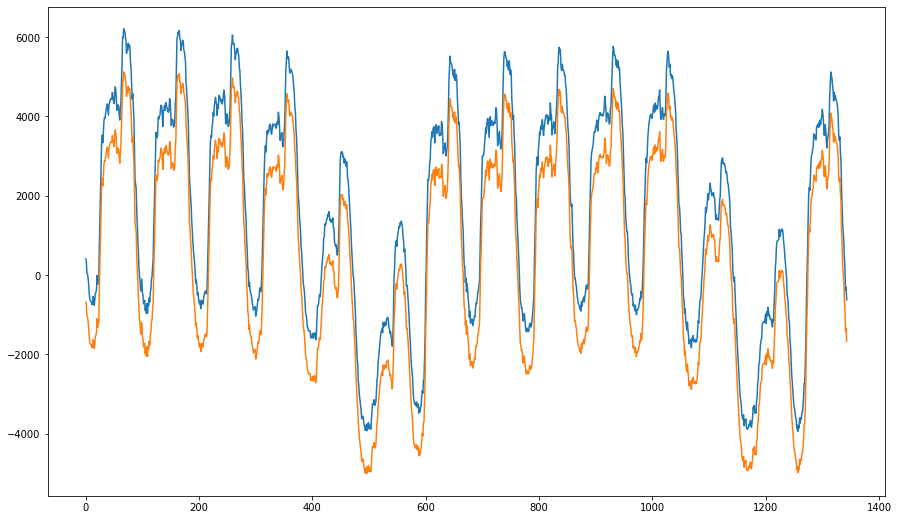

In [12]:
signal = Electric.Load.to_numpy() - signal_reconstr
load = Electric.Load.to_numpy() - Electric.Load.mean()

plt.figure(figsize=(15, 9))
plt.plot(load[96*7:96*7*3])
plt.plot(signal[96*7:96*7*3])

##freq_day = 1. / (3600. * 24.)
##freq_time = [freq_day, freq_day / 7., freq_day / 365.]
##power_sctr = np.abs(x_freqdom)

##
##plt.plot(f, power_sctr, lw=0.5)
##plt.plot(f[power_sctr <= freq_time[0]], power_sctr[power_sctr <= freq_time[0]], lw=0.5)

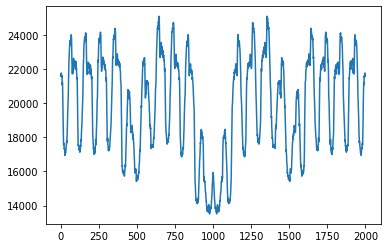

In [6]:
plt.plot(np.concatenate([Electric.Load.values[:1000][::-1], Electric.Load.values[:1000]]))
#plt.xlim(900,1000)

In [ ]:
# prima di fare le analisi bisogna estendere 
# il segnale in modo tale da eliminare gli effetti sui bordi dati dalla
# convoluzione.

In [8]:
def psf_forecasting(df, feature, wavelet='sym4', thr=0.04, plot=False):
    
    if feature == 'load_denoised':    
        df[feature] = wavelet_filter(df['Load'].to_numpy(), 
                                     wavelet=wavelet,
                                     threshold=thr)
    else:
        pass

    f = {feature: ['mean', 'std']}
    psfs = df.groupby(['Hour',
                       'Minutes']).agg(f).reset_index()[feature].to_numpy()

    psf = psfs[:, 0]
    psf_up = psf + 1.96 * psfs[:, 1]
    psf_low = psf - 1.96 * psfs[:, 1]

    load = df[feature].to_numpy()
    deconv_psf = deconvolution(load, psf)
    deconv_psfup = deconvolution(load, psf_up)
    deconv_psflow = deconvolution(load, psf_low)

    load_psf = np.convolve(deconv_psf, psf, 'valid')[:-96]
    load_up = np.convolve(deconv_psfup, psf_up, 'valid')[:-96]
    load_low = np.convolve(deconv_psflow, psf_low, 'valid')[:-96]

    if plot:
        psf_forecast_plot(Electric, load_psf, load_up, load_low, load)
    else:
        pass

    return load_psf


def psf_forecast_plot(df, load_psf, load_q1, load_q2, load):
    t = df.Date.iloc[:-191]

    #plt.figure(figsize=(12, 9))
    plt.plot(t, load_psf, 'b', lw=0.1, label='psf')
    plt.fill_between(x=t, y1=load_q1, y2=load_q2, color='b', lw=0.1, alpha=0.5,
                    label='psf quantiles (ci=95%)')
    plt.plot(t, load[:-191], 'r', lw=0.1, alpha=0.5, label='data')
    plt.grid()
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Load (MWh)')

    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.tight_layout()
    #leg = plt.legend()

    #for lh in leg.legendHandles: 
        #lh.set_alpha(1)
        #lh.set_linewidth(1)

In [9]:
def find_optimal_threshold(df, forecasting_func, thresholds,
                           wavelets=['coif5', 'sym4', 'sym5']):
    n = len(thresholds)
    m = len(wavelets)
    mses = np.zeros((n, m))
    forecast_noise = forecasting_func(df, 'Load')
    mse_noise = mse(df.Load.to_numpy()[:-191], forecast_noise)

    for j, wavelet in enumerate(wavelets):
        for i, thr in enumerate(thresholds):
            print(i, thr)
            forecast_denoised = forecasting_func(df, 'load_denoised',
                                                 wavelet, thr)
            mse_denoised = mse(df.Load.to_numpy()[:-191], forecast_denoised)
            mses[i, j] = mse_denoised
    
    return mse_noise, mses


In [10]:
thresholds = np.arange(0.1, 1.0, 0.1)
n = len(thresholds)
mse_noise, mses = find_optimal_threshold(Electric, psf_forecasting, 
                                         thresholds)

0 0.1
1 0.2
2 0.30000000000000004
3 0.4
4 0.5
5 0.6
6 0.7000000000000001
7 0.8
8 0.9
0 0.1
1 0.2
2 0.30000000000000004
3 0.4
4 0.5
5 0.6
6 0.7000000000000001
7 0.8
8 0.9
0 0.1
1 0.2
2 0.30000000000000004
3 0.4
4 0.5
5 0.6
6 0.7000000000000001
7 0.8
8 0.9


In [11]:
x, y = np.where(mses == np.min(mses))
thresholds[x], mses[x, y]

(array([0.3]), array([6792655.34803039]))

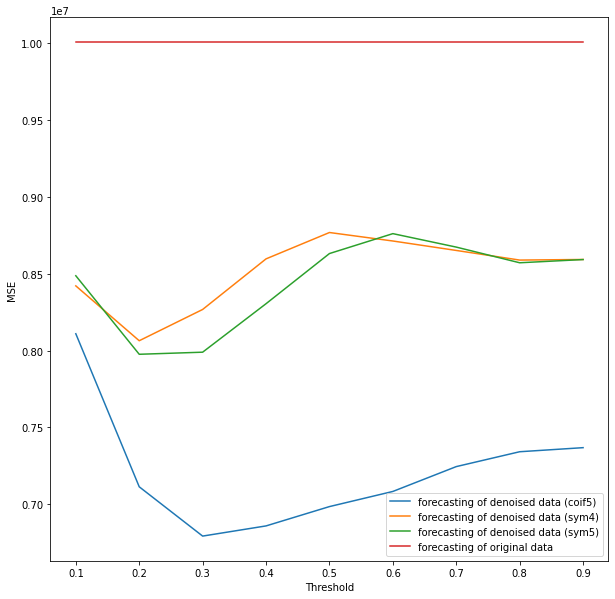

In [12]:
plt.figure(figsize=(10, 10))
wavelets = ['coif5', 'sym4', 'sym5']
for i, wavelet in enumerate(wavelets):
    plt.plot(thresholds, mses[:, i], label=f'forecasting of denoised data ({wavelet})')
plt.plot(thresholds, [mse_noise]*n, label='forecasting of original data')
#plt.plot(thresholds[np.argmin(mses)], mses.min(), 'xr') #, label='Minimum mse')
plt.xlabel('Threshold')
plt.ylabel('MSE')
plt.legend()
#thresholds[np.argmin(mses)], mses.min()

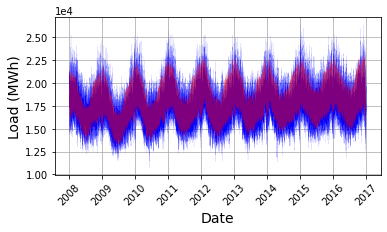

In [15]:
load_psf = psf_forecasting(Electric, 'load_denoised', 'coif5', 0.3, True)
#plt.savefig('../Images/Psf_forecasting', dpi=800);

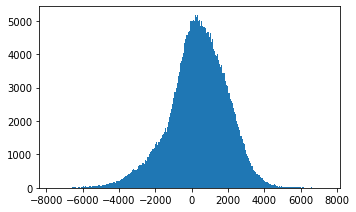

In [16]:
plt.hist(Electric.load_denoised.to_numpy()[:-191] - load_psf, bins='auto');

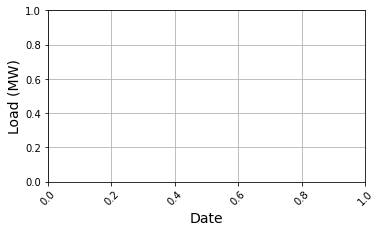

In [18]:
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.xticks(rotation=45)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#leg = plt.legend()

#for lh in leg.legendHandles: 
 #   lh.set_alpha(1)
  #§  lh.set_linewidth(1)
plt.grid()
plt.tight_layout()
#plt.savefig('../Images/Wavelet_denoise', dpi=800)